<a href="https://colab.research.google.com/github/alexjochs/ECE_539_Penguins/blob/preprocess/PenguinsPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive

# Alex
# drive.mount('/content/gdrive')
# gdrive_data_filepath = r"/content/gdrive/MyDrive/'Penguin_counting'/data_peng_watch"
# Oscar
drive.mount('/content/drive')
gdrive_data_filepath = r'/content/drive/MyDrive/Colab\ Notebooks/539\ Project/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
from matplotlib import image
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy.spatial import KDTree
import h5py
import time
from PIL import Image
import glob
import math

In [69]:
MASTER_LIST = ['BAILa', 'DAMOa', 'HALFb', 'HALFc', 'LOCKb', 'MAIVb', 'MAIVc', 'NEKOa', 'NEKOb', 'NEKOc', 'PETEc', 'PETEd', 'PETEf', 'SPIGa', 'GEORa']
VM_ROOT = r'/content'
cwd = None
def get_new_batch(target=None):
    assert target is not None, f"can't get specific folder: {target} and load all data"
    tgz_name = target + '.tgz'
    folder_path = os.path.join(gdrive_data_filepath, tgz_name)
    !tar --gunzip --extract --file={folder_path} --directory {VM_ROOT}
    cwd = os.path.join(VM_ROOT, target)

def save_batch_to_drive(target=None):
    # take working files, save them back to Gdrive
    assert target is not None, f"can't get specific folder: {target} and load all data"
    tgz_name = target + '.tgz'
    folder_path = os.path.join(VM_ROOT, target)
    os.chdir('/content/drive/MyDrive/Colab Notebooks/539 Project/data')
    !tar -czvf {tgz_name} -P {folder_path}

In [4]:
annotations_path = VM_ROOT + r'/CompleteAnnotations_2016-07-11'

def run_all():
    json_filepath_list = get_json_files_from_folder()
    for filepath in json_filepath_list:
        df = run(filepath_=filepath)
        save_df_as_json(df)

def run(filepath_=None, target=None):
    if target is not None:
        filepath_ = annotations_path + r'/' + target + '.json'
    data_group_name = filepath_[-10:-5]
    df = load_json_as_df(filepath_)
    df.loc[df.xy.isnull(), 'xy'] = [[]]
    # have to check if inner list has na values as well :/
    df_xy_ = to_1D(df['xy'])
    if df_xy_.isna().sum() > 0:
        df_xy_na_mask = df_xy_.isna()
        df.loc[df_xy_na_mask, 'xy'] = [[]]
    return df

def save_df_as_json(df):
    data_group_filename = df['imName'].iloc[0][:5] + '.json'
    try:
        os.mkdir('/content/annotations')
    except FileExistsError as e:
        print('looks like local annotations folder already exists!')
    print(data_group_filename)
    with open(os.path.join('/content/annotations', data_group_filename), 'w') as json_file:
        json.dump(json.loads(df.to_json(orient='records')), json_file)

def get_json_files_from_folder():
    json_filepath_list = []
    for filename in os.listdir(annotations_path):
        f = os.path.join(annotations_path, filename)
        if os.path.isfile(f):
            file_extension = os.path.splitext(f)[1]
        if file_extension == '.json':
            json_filepath_list.append(f)
    return json_filepath_list

def load_json_as_df(filepath):
    with open(filepath,'r') as json_file:
        json_data = json.loads(json_file.read())
    return pd.json_normalize(json_data, record_path =['dots'])

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [5]:
# dots: 2d list of xy dots from users
# return longest (ie most penguins clicked) 1d list
def get_longest_dot_list(dots):
    if len(dots) == 0:
        return []
    if not type(dots[0]) == type([]):
        return []
    idx = 0
    if len(dots) > 1:
        for i, x in enumerate(dots):
            if len(x) > len(dots[idx]):
                idx = i
    return dots[idx]

# One hot encoding of user clicks
def make_sparse_mat(img_shape, dots):
    mat = np.zeros((img_shape[0], img_shape[1]))
    for dot in dots:
        mat[dot[1], dot[0]] = 1

    return mat

def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        # density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        input_ = np.fft.fft2(pt2d)
        result = scipy.ndimage.fourier_gaussian(input_, sigma)
        density = np.add(density, np.fft.ifft2(result).real, casting="unsafe")
    
    return density

In [ ]:

df = run(target='BAILa')
print(df)

                 imName                                                 xy
0     BAILa2014a_000001  [[[350, 1455], [849, 1327], [1129, 1042], [73,...
1     BAILa2014a_000002                                                 []
2     BAILa2014a_000003  [[[48, 293], [62, 293], [46, 319], [71, 314], ...
3     BAILa2014a_000004  [[[1340, 1140], [914, 1335], [192, 1162], [35,...
4     BAILa2014a_000005  [[[1022, 1309], [161, 1167], [23, 875], [530, ...
...                 ...                                                ...
5208  BAILa2014a_005209                                                 []
5209  BAILa2014a_005210                                                 []
5210  BAILa2014a_005211                                            [_NaN_]
5211  BAILa2014a_005212                                            [_NaN_]
5212  BAILa2014a_005213                                                 []

[5213 rows x 2 columns]


In [ ]:
os.chdir(VM_ROOT + '/BAILa') # TODO
for i, row in df.iterrows():
    img_name = row['imName']
    img_dots = row['xy']
    img = image.imread(os.path.join('/content/BAILa', row['imName']) + '.JPG') # TODO

    dots = get_longest_dot_list(img_dots)
    k = make_sparse_mat(img.shape, dots)
    start_time = time.time()
    k = gaussian_filter_density(k)
    print(f"--- {(time.time() - start_time)} seconds ---")

    break

    with h5py.File(img_name+'_gt.h5', 'w') as f:
        f['density'] = k

KeyboardInterrupt: ignored

some ideas to improve speed:  
- load all images into memory
- downsample images to input size
- - w/ fft, down to 4 sec!
- use mutiprocessing to speed up execution
- use fft instead of gaussian filter?
- - It works! down to 35 sec per image

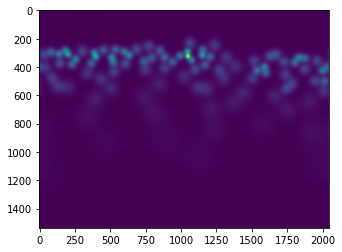

In [ ]:
plt.imshow(k)

In [73]:
original_img_dim = {'BAILa': (2048, 1536), 'DAMOa': (2048, 1536), 'HALFb': (2048, 1536), 'HALFc': (1920, 1080), 'LOCKb': (1920, 1080), 'MAIVb': (2048, 1536), 'MAIVc': (2048, 1536), 'NEKOa': (1920, 1080), 'NEKOb': (2048, 1536), 'NEKOc': (2048, 1536), 'PETEc': (2048, 1536), 'PETEd': (2048, 1536), 'PETEf': (2048, 1536), 'SPIGa': (1920, 1080), 'GEORa': (2048, 1536)}
def downsample_dots(dots, img_shape):
    """convert xy coords of annotations down to 600x800 img space"""
    ds_dots = []
    original_dim = original_img_dim[data_split_name] # TODO CHANGE TO IMAGE SIZE FROM PARAM
    x_scaler = 800.0 / float(original_dim[0])
    y_scaler = 600.0 / float(original_dim[1])
    for dot in dots:
        ds_dots.append([math.floor(dot[0] * x_scaler), math.floor(dot[1] * y_scaler)])
        if math.floor(dot[0] * x_scaler) > 800 or math.floor(dot[1] * y_scaler) > 800:
            print(dot, x_scaler, y_scaler, data_split_name)
    return ds_dots

In [19]:
# TODO LOAD ANNOTATIONS

# slice working list to split workload between us
working_list = MASTER_LIST[:]

# load data in to VM HDD first
for data_split_name in working_list:
    get_new_batch(data_split_name)
    break # TODO



^C


Cell below loads image sizes into original image data dict, which is something like {'BAILa': (2048, 1536), 'DAMOa': (2048, 1536), 'HALFb': (2048, 1536), 'HALFc': (1920, 1080), etc...

In [20]:
original_img_dim = {}
for data_split_name in working_list:
    local_directory = os.path.join(VM_ROOT, data_split_name)
    for filename in glob.glob(local_directory + '/*.' + 'JPG'): #assuming gif
        im=Image.open(filename)
        original_img_dim[data_split_name] = (im.size[0], im.size[1])
        break

---
The greatest of for loops:  
- for every datasplit in the master list:
    - get images for datasplit, load in to ram
    - get annotations, store in a df
    - get image size for that datasplit (each split is diff)
    - for **every image in datasplit**:  
        - downsample image to (600,800)
        - downsample annotations
        - get groundtruth of image via fft
        - save downsampled image and downsampled groundtruth

In [23]:
original_img_dim

{'BAILa': (2048, 1536),
 'DAMOa': (2048, 1536),
 'GEORa': (2048, 1536),
 'HALFb': (2048, 1536),
 'HALFc': (1920, 1080),
 'LOCKb': (1920, 1080),
 'MAIVb': (2048, 1536),
 'MAIVc': (2048, 1536),
 'NEKOa': (1920, 1080),
 'NEKOb': (2048, 1536),
 'NEKOc': (2048, 1536),
 'PETEc': (2048, 1536),
 'PETEd': (2048, 1536),
 'PETEf': (2048, 1536),
 'SPIGa': (1920, 1080)}

In [77]:
# get_new_batch('CompleteAnnotations_2016-07-11') TODO
for data_split_name in working_list:
    # Create split dir of ground truths
    split_dir = os.path.join(VM_ROOT, data_split_name + '_gt')
    os.mkdir(split_dir)
    os.chdir(split_dir)

    # Get annotations as DataFrame
    df = run(target=data_split_name)

    # Create heatmap for each image
    for i, row in df.iterrows():
        # downsample dots to new img size of 600,800
        img_dots = row['xy']
        dots = get_longest_dot_list(img_dots)
        ds_dots = downsample_dots(dots, data_split_name)

        # make gt heatmap
        k_ds = make_sparse_mat((600, 800), ds_dots)
        k_ds = gaussian_filter_density(k_ds)

        # save file as an h5 type
        with h5py.File(row['imName'] + '_gt.h5', 'w') as f:
            f['density'] = k_ds

        # TODO
        if i > 10:
            break

    # Save ground truth zip
    save_batch_to_drive(target=data_split_name + '_gt')

/content/BAILa_gt/
/content/BAILa_gt/BAILa2014a_000007_gt.h5
/content/BAILa_gt/BAILa2014a_000002_gt.h5
/content/BAILa_gt/BAILa2014a_000001_gt.h5
/content/BAILa_gt/BAILa2014a_000006_gt.h5
/content/BAILa_gt/BAILa2014a_000009_gt.h5
/content/BAILa_gt/BAILa2014a_000012_gt.h5
/content/BAILa_gt/BAILa2014a_000003_gt.h5
/content/BAILa_gt/BAILa2014a_000011_gt.h5
/content/BAILa_gt/BAILa2014a_000004_gt.h5
/content/BAILa_gt/BAILa2014a_000010_gt.h5
/content/BAILa_gt/BAILa2014a_000005_gt.h5
/content/BAILa_gt/BAILa2014a_000008_gt.h5
/content/DAMOa_gt/
/content/DAMOa_gt/DAMOa2014a_000003_gt.h5
/content/DAMOa_gt/DAMOa2014a_000012_gt.h5
/content/DAMOa_gt/DAMOa2014a_000005_gt.h5
/content/DAMOa_gt/DAMOa2014a_000007_gt.h5
/content/DAMOa_gt/DAMOa2014a_000001_gt.h5
/content/DAMOa_gt/DAMOa2014a_000009_gt.h5
/content/DAMOa_gt/DAMOa2014a_000006_gt.h5
/content/DAMOa_gt/DAMOa2014a_000010_gt.h5
/content/DAMOa_gt/DAMOa2014a_000008_gt.h5
/content/DAMOa_gt/DAMOa2014a_000002_gt.h5
/content/DAMOa_gt/DAMOa2014a_000004_gt

IndexError: ignored

In [ ]:
# open each image
img = Image.open(os.path.join('/content', data_split_name, row['imName']) + '.JPG')
img.size
img = img.resize((800, 600), Image.ANTIALIAS)
        # image_list.append(img) TODO

In [76]:
!rm -rf /content/BAILa_gt
!rm -rf /content/DAMOa_gt
!rm -rf /content/HALFb_gt

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
